# PERCEPTRON

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [ ]:
iris = load_iris()
X = iris.data[:, (2,3)] #petal length, petal width
y = (iris.target == 0).astype(np.int)

In [ ]:
per_clf = Perceptron(random_state=42)
per_clf.fit(X,y)

In [ ]:
y_pred = per_clf.predict([[2,0.5]])
y_pred

# Activation Functions

[-5, 5, -1.2, 1.2]

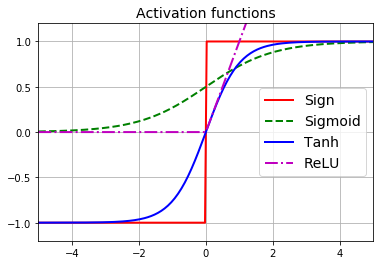

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1/ (1+np.exp(-z))

def tanh(z):
    return (np.exp(2*z)-1)/(np.exp(2*z)+1)

def heaviside(z):
    return (z >= 0).astype(z.dtype)


z = np.linspace(-5, 5, 200)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Sign")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

# Training a DNN Using Plain Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs =10

X= tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y= tf.placeholder(tf.int64, shape=(None), name="y")

In [ ]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/ np.sqrt(n_inputs +n_neurons)
        init = tf.truncated_normal(shape=(n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name ="kernel")
        b = tf.Variable(tf.zeros(shape=[n_neurons]), name="bias")
        Z = tf.matmul(X,W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="output") # for optimization reasons, we will handle softmax computation layer

In [ ]:
with tf.name_scope("loss"):
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
    loss = tf.reduce_mean(entropy, name="loss")

In [ ]:
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    trainer = optimizer.minimize(loss)

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(predictions = logits, targets = y, k=1)
    accuracy =tf.reduce_mean(tf.cast(correct,tf.float32))

In [ ]:
init = tf.global_variables_initializer()
saver=tf.train.Saver()

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

In [ ]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(trainer, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

In [ ]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(tf.get_default_graph())

One can use tf.layers.dense() instead if defining the layers by hand

In [ ]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

# Full program

In [ ]:
import tensorflow as tf
import numpy as np
import os

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs =10

X= tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y= tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
    loss = tf.reduce_mean(entropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)
    
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    trainer = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(predictions = logits, targets = y, k=1)
    accuracy =tf.reduce_mean(tf.cast(correct,tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)
    
init = tf.global_variables_initializer()
saver=tf.train.Saver()

from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

logdir = "mnist_dnn"

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")
X_valid = mnist.validation.images
y_valid = mnist.validation.labels.astype("int")

In [ ]:
m, n = X_train.shape

In [ ]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch, n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(trainer, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 1 == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
                checks_without_progress = 0
                save_message = "*"
            else:
                epochs_without_progress += 1
                save_message = ""
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping!")
                    break
            print("Epoch {:d}: ".format(epoch), \
                  "Validation Loss: {:.6f}, ".format(loss_val), \
                  "Validation Accuracy: {:.3f}%".format(accuracy_val*100),\
                   save_message)
            #this wont print the very last epoch information!

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})

In [ ]:
 accuracy_val